## Interpretation of models trained on UniProtKB Coronaviridae S protein dataset for multiclass classification

### Dataset: UniProtKB  - Spike protein sequences from coronaviridae
### Sequences aligned using MAFFT

**Models**: FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 2169

**Classification**: Multi-class

**\# classes**: 7

**\# train samples** = 4,092

**\# test samples** = 1,023

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_noteboo

In [2]:
from models.nlp.transformer import transformer, transformer_model
from models.nlp import cnn1d, lstm
from models.nlp.fnn import fnn
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from src.utils import utils, nn_utils
from models.nlp.embedding.padding import Padding

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from captum.attr import LayerIntegratedGradients, TokenReferenceBase, LayerGradientXActivation, LayerDeepLift, LayerLRP

In [3]:
label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 2169,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 2169,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [4]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    
    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))

def print_dataset_loader(dataset_loader):
    sequence, label = next(iter(dataset_loader))
    print(f"Sequence tensor size = {sequence.shape}")
    print(f"Sequence = {sequence}")
    print(f"Label tensor size = {label.shape}")
    print(f"Label = {label}")

In [5]:
uniprotkb_coronaviruses_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_host_aligned.csv")
uniprotkb_coronaviruses_df.head()

,id,seq,virus,seq_len,virus_host,binary_label,seq_aligned,aligned_seq_len,aligned_token_count
0,A3EX94,MTLLMCLLMSLLIFVRGCDSQFVDMSPASNTSECLESQVDAAAFSK...,Bat coronavirus HKU4 (BtCoV) (BtCoV/HKU4/2004),1352,Tylonycteris pachypus (Lesser bamboo bat) (Ves...,Not Human,--MTLLMCLLMSLLIFV----RG-CDSQFVDMSPASNTSECLES--...,2169,1352
1,A3EXD0,MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFES...,Bat coronavirus HKU5 (BtCoV) (BtCoV/HKU5/2004),1352,Pipistrellus abramus (Japanese pipistrelle) (P...,Not Human,--MIRSVLVLMCSLTFI----GNLTRGQSVDMGHNGTGS-CLDS--...,2169,1352
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human,---------MFVFLVLL-----------------------------...,2169,1273
3,P11223,MLVTPLLLVTLLCALCSAVLYDSSSYVYYYQSAFRPPSGWHLQGGA...,Avian infectious bronchitis virus (strain Beau...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human,--MLVTP---LLLVTLLC------ALCSAVLY----DSSSYV----...,2169,1162
4,P12651,MLVTPLLLVTLLCVLCSAALYDSSSYVYYYQSAFRPPNGWHLHGGA...,Avian infectious bronchitis virus (strain M41)...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human,--MLVTP---LLLVTLLC------VLCSAALY----DSSSYV----...,2169,1162


In [6]:
uniprotkb_coronaviruses_df["virus_host"].value_counts()

Sus scrofa (Pig) [TaxID: 9823]                                                                  2620
Homo sapiens (Human) [TaxID: 9606]                                                              2400
Meleagris gallopavo (Wild turkey) [TaxID: 9103]                                                   36
Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]      19
Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]                  17
Gallus gallus (Chicken) [TaxID: 9031]                                                             13
Bos taurus (Bovine) [TaxID: 9913]                                                                 10
Name: virus_host, dtype: int64

In [7]:
def get_target_dataset_loader(target):
    uniprotkb_coronaviruses_target_df = uniprotkb_coronaviruses_df[uniprotkb_coronaviruses_df["virus_host"] == target]
    print(f"Size {target} df = {uniprotkb_coronaviruses_target_df.shape}")
    return get_token_dataset_loader(uniprotkb_coronaviruses_target_df, test_sequence_settings, label_settings)

In [8]:
index_label_map, coronavirus_dataset_loader = get_token_dataset_loader(uniprotkb_coronaviruses_df, test_sequence_settings, label_settings)

Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

### Load the trained models

#### Model: TF trained on Coronaviridae S protein dataset
#### Training Dataset: UniProtKB Coronaviridae 5K (coronaviridae_top_7_host_aligned.csv)
#### max sequence length: 2169


In [9]:
models_dir = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20231008"

#### CNN Model

In [10]:
model["kernel_size"] = 3
model["stride"] = 1
model["depth"] = 4
cnn_model = cnn1d.get_cnn_model(model)
cnn_model.load_state_dict(torch.load(os.path.join(models_dir, "aligned_host_multi_lr1e-3-e50", "cnn-l_4-lr1e-3_itr0.pth")))
cnn_model = cnn_model.to(nn_utils.get_device())
cnn_model.eval()
cnn_model.zero_grad()

CNN_1D_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (conv1d): Conv1d(512, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden): Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  (conv1d_hidden_layers): ModuleList(
    (0-2): 3 x Conv1d(1024, 1024, kernel_size=(3,), stride=(1,))
  )
  (linear): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  14181895


#### LSTM Model

In [11]:
model["depth"] = 2
lstm_model = lstm.get_lstm_model(model)
lstm_model.load_state_dict(torch.load(os.path.join(models_dir, "aligned_host_multi_lr1e-3-e50", "lstm-l_2-lr1e-3_itr0.pth")))
lstm_model = lstm_model.to(nn_utils.get_device())

LSTM_Model(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (lstm): LSTM(512, 1024, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1024, out_features=7, bias=True)
)
Number of parameters =  14717447


#### TF - Pytorch Model

In [ ]:
model["depth"] = 6
tf_pytorch_model = transformer_model.get_transformer_model(model)
tf_pytorch_model.load_state_dict(torch.load(os.path.join(models_dir, "host_multi_lr1e-3-e50", "transformer-l_6-h_8-lr1e-3_itr0.pth")))
tf_pytorch_model = tf_pytorch_model.to(nn_utils.get_device())
tf_pytorch_model.eval()
tf_pytorch_model.zero_grad()

#### TF - Custom Model

In [13]:
model["depth"] = 6
tf_custom_model = transformer.get_transformer_model(model)
tf_custom_model.load_state_dict(torch.load(os.path.join(models_dir, "aligned_host_multi_lr1e-3-e50", "transformer-l_6-h_8-lr1e-3_itr0.pth")))
tf_custom_model = tf_custom_model.to(nn_utils.get_device())
tf_custom_model.eval()
tf_custom_model.zero_grad()

Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=7, b

### Prediction Performance

In [14]:
def validate(model, dataset_loader):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df["y_true"] = labels.cpu().numpy()
            results.append(result_df)
    
    return pd.concat(results, ignore_index=True)

In [15]:
results = validate(tf_custom_model, coronavirus_dataset_loader)

In [16]:
results_df = results.rename(columns=index_label_map)
results_df["y_true"] = results_df["y_true"].map(lambda x: index_label_map[x])
results_df

,Bovine,Chicken,Human,Japanese pipistrelle,Lesser bamboo bat,Pig,Wild turkey,y_true
0,0.007732,0.000226,0.001154,0.003558,0.000099,0.987224,0.000006,Pig
1,0.011278,0.000239,0.971452,0.001914,0.007339,0.005506,0.002273,Human
2,0.002350,0.012784,0.747044,0.000352,0.000619,0.209338,0.027512,Human
3,0.004548,0.000038,0.973962,0.000927,0.001406,0.018942,0.000177,Human
4,0.007713,0.000224,0.001179,0.003576,0.000099,0.987203,0.000006,Pig
...,...,...,...,...,...,...,...,...
5110,0.002757,0.000070,0.937008,0.000472,0.000505,0.058980,0.000209,Human
5111,0.003890,0.000039,0.978024,0.000804,0.001227,0.015839,0.000177,Human
5112,0.006246,0.000401,0.000576,0.003830,0.000086,0.988855,0.000006,Pig
5113,0.010274,0.000210,0.001239,0.003575,0.000125,0.984570,0.000008,Pig


In [17]:
auprcs = []
for i in index_label_map.values():
    precision, recall, _ = precision_recall_curve(y_true=results_df["y_true"].values, probas_pred=results_df[i].values, pos_label=i)
    auprc = auc(recall, precision)
    print(f"AUPRC for class {i} = {auprc}")
    auprcs.append(auprc)

macro_auprc = mean(auprcs)
print(f"Macro AUPRC = {macro_auprc}")

AUPRC for class Bovine = 1.0
AUPRC for class Chicken = 0.8469106550688029
AUPRC for class Human = 0.9998935735019039
AUPRC for class Japanese pipistrelle = 1.0
AUPRC for class Lesser bamboo bat = 1.0
AUPRC for class Pig = 0.999225520525026
AUPRC for class Wild turkey = 1.0
Macro AUPRC = 0.978004249870819


## Intepretation

In [18]:
def compute_top_n_positions(attr_df, n):
    attr_rank_df = attr_df.abs().rank("columns", ascending=False).astype(int)
    # retain only top n ranks
    attr_rank_df[attr_rank_df > n] = None
    # drop all columns (positions) with all NaN i.e. this position is not in the top 10 for any sequence
    attr_rank_df.dropna(axis=1, how="all", inplace=True)
    print(attr_rank_df.columns)
    print(attr_rank_df.head(20))
    sns.heatmap(data=attr_df[attr_rank_df.columns])
    plt.show()

#### Inputs

In [19]:
human_inputs = []
_, human_dataset_loader = get_target_dataset_loader("Homo sapiens (Human) [TaxID: 9606]")
for i in range(20):
    human_inputs.append(next(iter(human_dataset_loader)))
    
pig_inputs = []
_, pig_dataset_loader = get_target_dataset_loader("Sus scrofa (Pig) [TaxID: 9823]")
for i in range(20):
    pig_inputs.append(next(iter(pig_dataset_loader)))

Size Homo sapiens (Human) [TaxID: 9606] df = (2400, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Size Sus scrofa (Pig) [TaxID: 9823] df = (2620, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Huma

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

In [20]:
human_input = next(iter(human_dataset_loader))
pig_input = next(iter(pig_dataset_loader))

#### Outputs

In [21]:
n_attr_dfs = []
single_seq_attr_dfs = []

### LayerGradientXActivation

In [22]:
def compute_lgxa_attributions(model, inputs, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerGradientXActivation(model, model.embedding)
        attribution = interpreter.attribute(seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [23]:
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(cnn_model, human_inputs, target=2)
})

n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Pig",
    "attr_df": compute_lgxa_attributions(cnn_model, pig_inputs, target=5)
})

In [24]:
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(lstm_model, human_inputs, target=2)
})

n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Pig",
    "attr_df": compute_lgxa_attributions(lstm_model, pig_inputs, target=5)
})

In [25]:
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(cnn_model, [human_input], target=2)
})

single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerGradientXActivation",
    "class": "Pig",
    "attr_df": compute_lgxa_attributions(cnn_model, [pig_input], target=5)
})

In [26]:
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Human",
    "attr_df": compute_lgxa_attributions(lstm_model, [human_input], target=2)
})

single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerGradientXActivation",
    "class": "Pig",
    "attr_df": compute_lgxa_attributions(lstm_model, [pig_input], target=5)
})

### LayerIntegratedGradients

In [27]:
def compute_lig_attributions(model, inputs, target, reference_seq):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerIntegratedGradients(model, model.embedding)
        attribution = interpreter.attribute(seq, reference_seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [28]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(cnn_model, human_inputs, target=2, reference_seq=reference_seq)
})

n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Pig",
    "attr_df": compute_lig_attributions(cnn_model, pig_inputs, target=5, reference_seq=reference_seq)
})


In [29]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(lstm_model, human_inputs, target=2, reference_seq=reference_seq)
})

n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Pig",
    "attr_df": compute_lig_attributions(lstm_model, pig_inputs, target=5, reference_seq=reference_seq)
})

In [30]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(cnn_model, [human_input], target=2, reference_seq=reference_seq)
})

single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerIntegratedGradients",
    "class": "Pig",
    "attr_df": compute_lig_attributions(cnn_model, [pig_input], target=5, reference_seq=reference_seq)
})


In [31]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Human",
    "attr_df": compute_lig_attributions(lstm_model, [human_input], target=2, reference_seq=reference_seq)
})

single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerIntegratedGradients",
    "class": "Pig",
    "attr_df": compute_lig_attributions(lstm_model, [pig_input], target=5, reference_seq=reference_seq)
})

### LayerDeepLift

In [32]:
def compute_ldeeplift_attributions(model, inputs, reference_seq, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerDeepLift(model, model.embedding)
        attribution = interpreter.attribute(seq, baselines=reference_seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)

In [33]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(cnn_model, human_inputs, reference_seq, target=2)
})

n_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Pig",
    "attr_df": compute_ldeeplift_attributions(cnn_model, pig_inputs, reference_seq, target=5)
})

In [34]:
reference_seq = TokenReferenceBase(reference_token_idx=0).generate_reference(test_sequence_settings["max_sequence_length"],
                                                                       device=nn_utils.get_device()).unsqueeze(0)
n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(lstm_model, human_inputs, reference_seq, target=2)
})

n_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Pig",
    "attr_df": compute_ldeeplift_attributions(lstm_model, pig_inputs, reference_seq, target=5)
})

In [35]:
single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(cnn_model, [human_input], reference_seq, target=2)
})

single_seq_attr_dfs.append({
    "model": "CNN",
    "method": "LayerDeepLift",
    "class": "Pig",
    "attr_df": compute_ldeeplift_attributions(cnn_model, [pig_input], reference_seq, target=5)
})

In [36]:
single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Human",
    "attr_df": compute_ldeeplift_attributions(lstm_model, [human_input], reference_seq, target=2)
})

single_seq_attr_dfs.append({
    "model": "LSTM",
    "method": "LayerDeepLift",
    "class": "Pig",
    "attr_df": compute_ldeeplift_attributions(lstm_model, [pig_input], reference_seq, target=5)
})

### Attention - Only for Transformer

In [37]:
def compute_attention_attributions(tf_model, inputs):
    tf_model.eval()
    attn_dfs = []
    
    for seq, label in inputs:
        tf_model(seq)
        attn_values = tf_model.encoder.layers[5].self_attn.self_attn.squeeze()
        mean_attn_values = torch.mean(attn_values, dim=0)
        mean_of_mean = torch.mean(mean_attn_values, dim=0, keepdim=True)
        df = pd.DataFrame(mean_of_mean.cpu().detach().numpy())
        attn_dfs.append(df)

    return pd.concat(attn_dfs, axis=0)

In [38]:
n_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Human",
    "attr_df": compute_attention_attributions(tf_custom_model, human_inputs)
})

n_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Pig",
    "attr_df": compute_attention_attributions(tf_custom_model, pig_inputs)
})

In [39]:
single_seq_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Human",
    "attr_df": compute_attention_attributions(tf_custom_model, [human_input])
})

single_seq_attr_dfs.append({
    "model": "TF",
    "method": "Attention",
    "class": "Pig",
    "attr_df": compute_attention_attributions(tf_custom_model, [pig_input])
})

### LayerLRP

In [40]:
def compute_llrp_attributions(model, inputs, target):
    attributions = []
    for seq, label in inputs:
        interpreter = LayerLRP(model, model.embedding)
        attribution = interpreter.attribute(seq, target=target)
        
        attribution = attribution.sum(dim=2).squeeze(0)
        attribution = attribution / torch.norm(attribution)
        attributions.append(attribution.detach().cpu().numpy())
    return pd.DataFrame(attributions)


def compute_target_llrp_attributions(model, model_name, target, n=10):
    _, human_dataset_loader = get_target_dataset_loader(target)
    inputs = []
    for i in range(n):
        inputs.append(next(iter(human_dataset_loader)))
    interpret_results_df = compute_llrp_attributions(model, inputs, target=2)
    plot_top_n_attr(interpret_results_df, n=10)

In [ ]:
compute_target_llrp_attributions(cnn_model, "CNN", target="Homo sapiens (Human) [TaxID: 9606]", n=10)
compute_target_llrp_attributions(cnn_model, "CNN", target="Sus scrofa (Pig) [TaxID: 9823]", n=10)

In [ ]:
compute_target_llrp_attributions(lstm_model, "LSTM", target="Homo sapiens (Human) [TaxID: 9606]", n=10)
compute_target_llrp_attributions(lstm_model, "LSTM", target="Sus scrofa (Pig) [TaxID: 9823]", n=10)

### Visualization for n=20 Human sequences

In [40]:
n_attr_dfs

[{'model': 'CNN',
  'method': 'LayerGradientXActivation',
  'class': 'Human',
  'attr_df':         0         1         2         3         4         5         6     \
  0  -0.000197 -0.001168  0.003640 -0.006196 -0.005852  0.001196 -0.008434   
  1  -0.000142 -0.000260 -0.000686 -0.000104  0.000517 -0.006593  0.007155   
  2   0.000119  0.001127 -0.004089 -0.004971 -0.001695 -0.048577  0.006776   
  3  -0.000468 -0.001606 -0.001042 -0.001744 -0.002591 -0.008339  0.005829   
  4  -0.000549 -0.001881 -0.001221 -0.002044 -0.003035 -0.009769  0.006829   
  5   0.000424 -0.000230  0.007092 -0.022894  0.016135 -0.027323 -0.015500   
  6  -0.000532 -0.001823 -0.001183 -0.001980 -0.002941 -0.009466  0.006616   
  7   0.000334  0.000046 -0.001973  0.008487 -0.013025  0.002187 -0.000225   
  8  -0.000451  0.001163  0.019840 -0.031755 -0.001425  0.002031 -0.003927   
  9  -0.000021 -0.000292  0.000743  0.000422  0.014454  0.016629 -0.039115   
  10 -0.000201 -0.001191  0.003714 -0.006323 -0.00597

#### Attribution values for n=20 sequences for all model-method combinations - Human

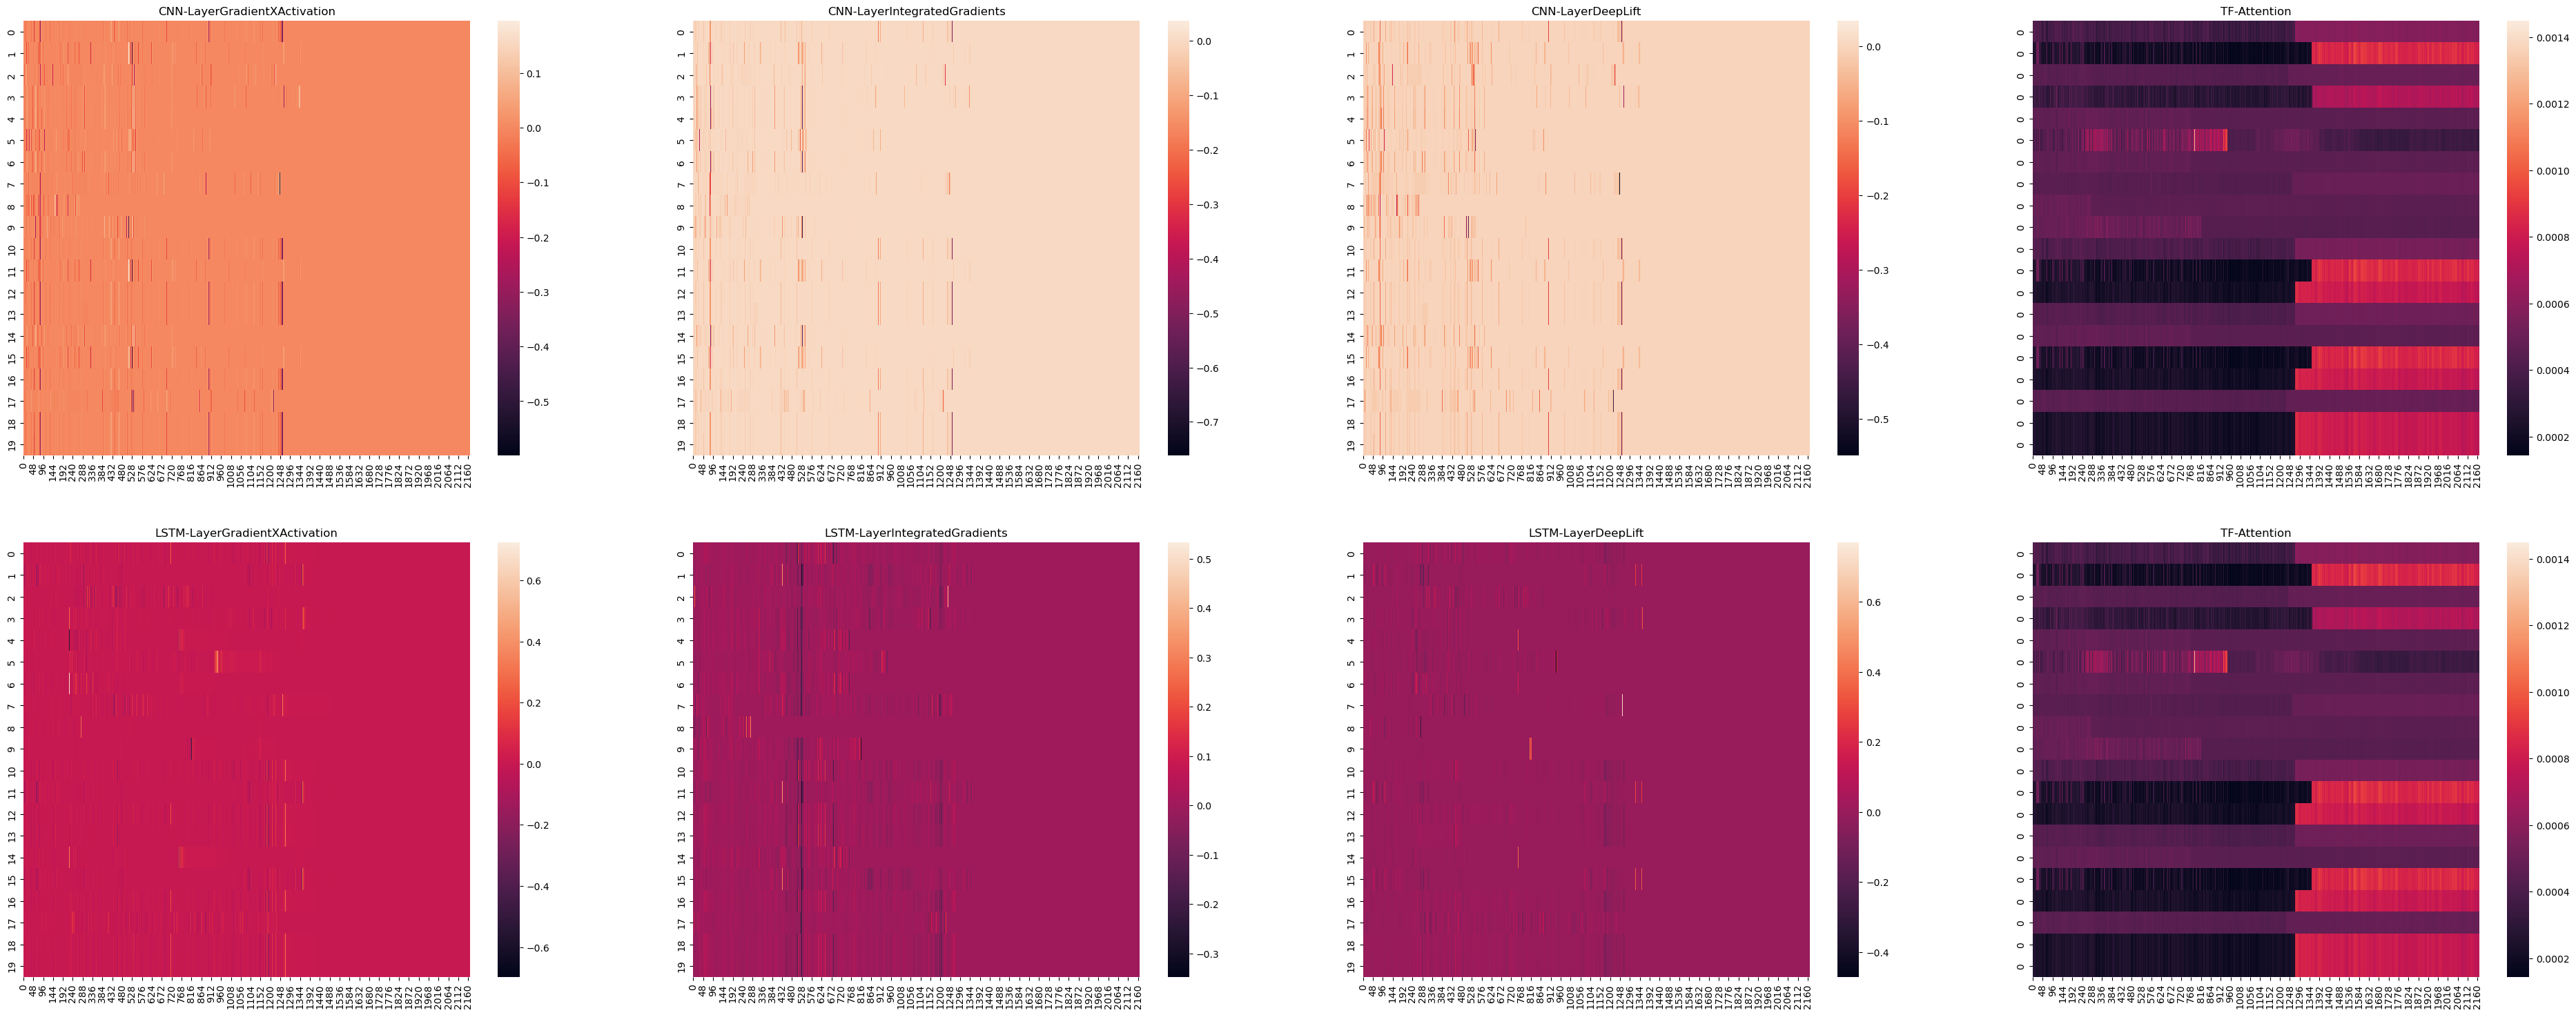

In [43]:
figs, axs = plt.subplots(2, 4, figsize=(48, 18))

def draw_subplot(model, method, class_name, ax):
    entry = list(filter(lambda x: x["model"] == model and x["method"] == method and x["class"] == class_name, n_attr_dfs))[0]
    df = entry["attr_df"]
    sns.heatmap(df, ax=ax)
    ax.set_title(f"{model}-{method}")


# 0, 0: CNN-LayerGradientXActivation
draw_subplot("CNN", "LayerGradientXActivation", "Human", axs[0, 0])

# 0, 1: CNN-LayerIntegratedGradients
draw_subplot("CNN", "LayerIntegratedGradients", "Human", axs[0, 1])

# 0, 2: CNN-LayerDeepLift
draw_subplot("CNN", "LayerDeepLift", "Human", axs[0, 2])

# 0, 3: TF-Attention
draw_subplot("TF", "Attention", "Human", axs[0, 3])

# 1, 0: LSTM-LayerGradientXActivation
draw_subplot("LSTM", "LayerGradientXActivation", "Human", axs[1, 0])

# 1, 1: LSTM-LayerIntegratedGradients
draw_subplot("LSTM", "LayerIntegratedGradients", "Human", axs[1, 1])

# 1, 2: LSTM-LayerDeepLift
draw_subplot("LSTM", "LayerDeepLift", "Human", axs[1, 2])

# 1, 3: TF-Attention
draw_subplot("TF", "Attention", "Human", axs[1, 3])

plt.show()

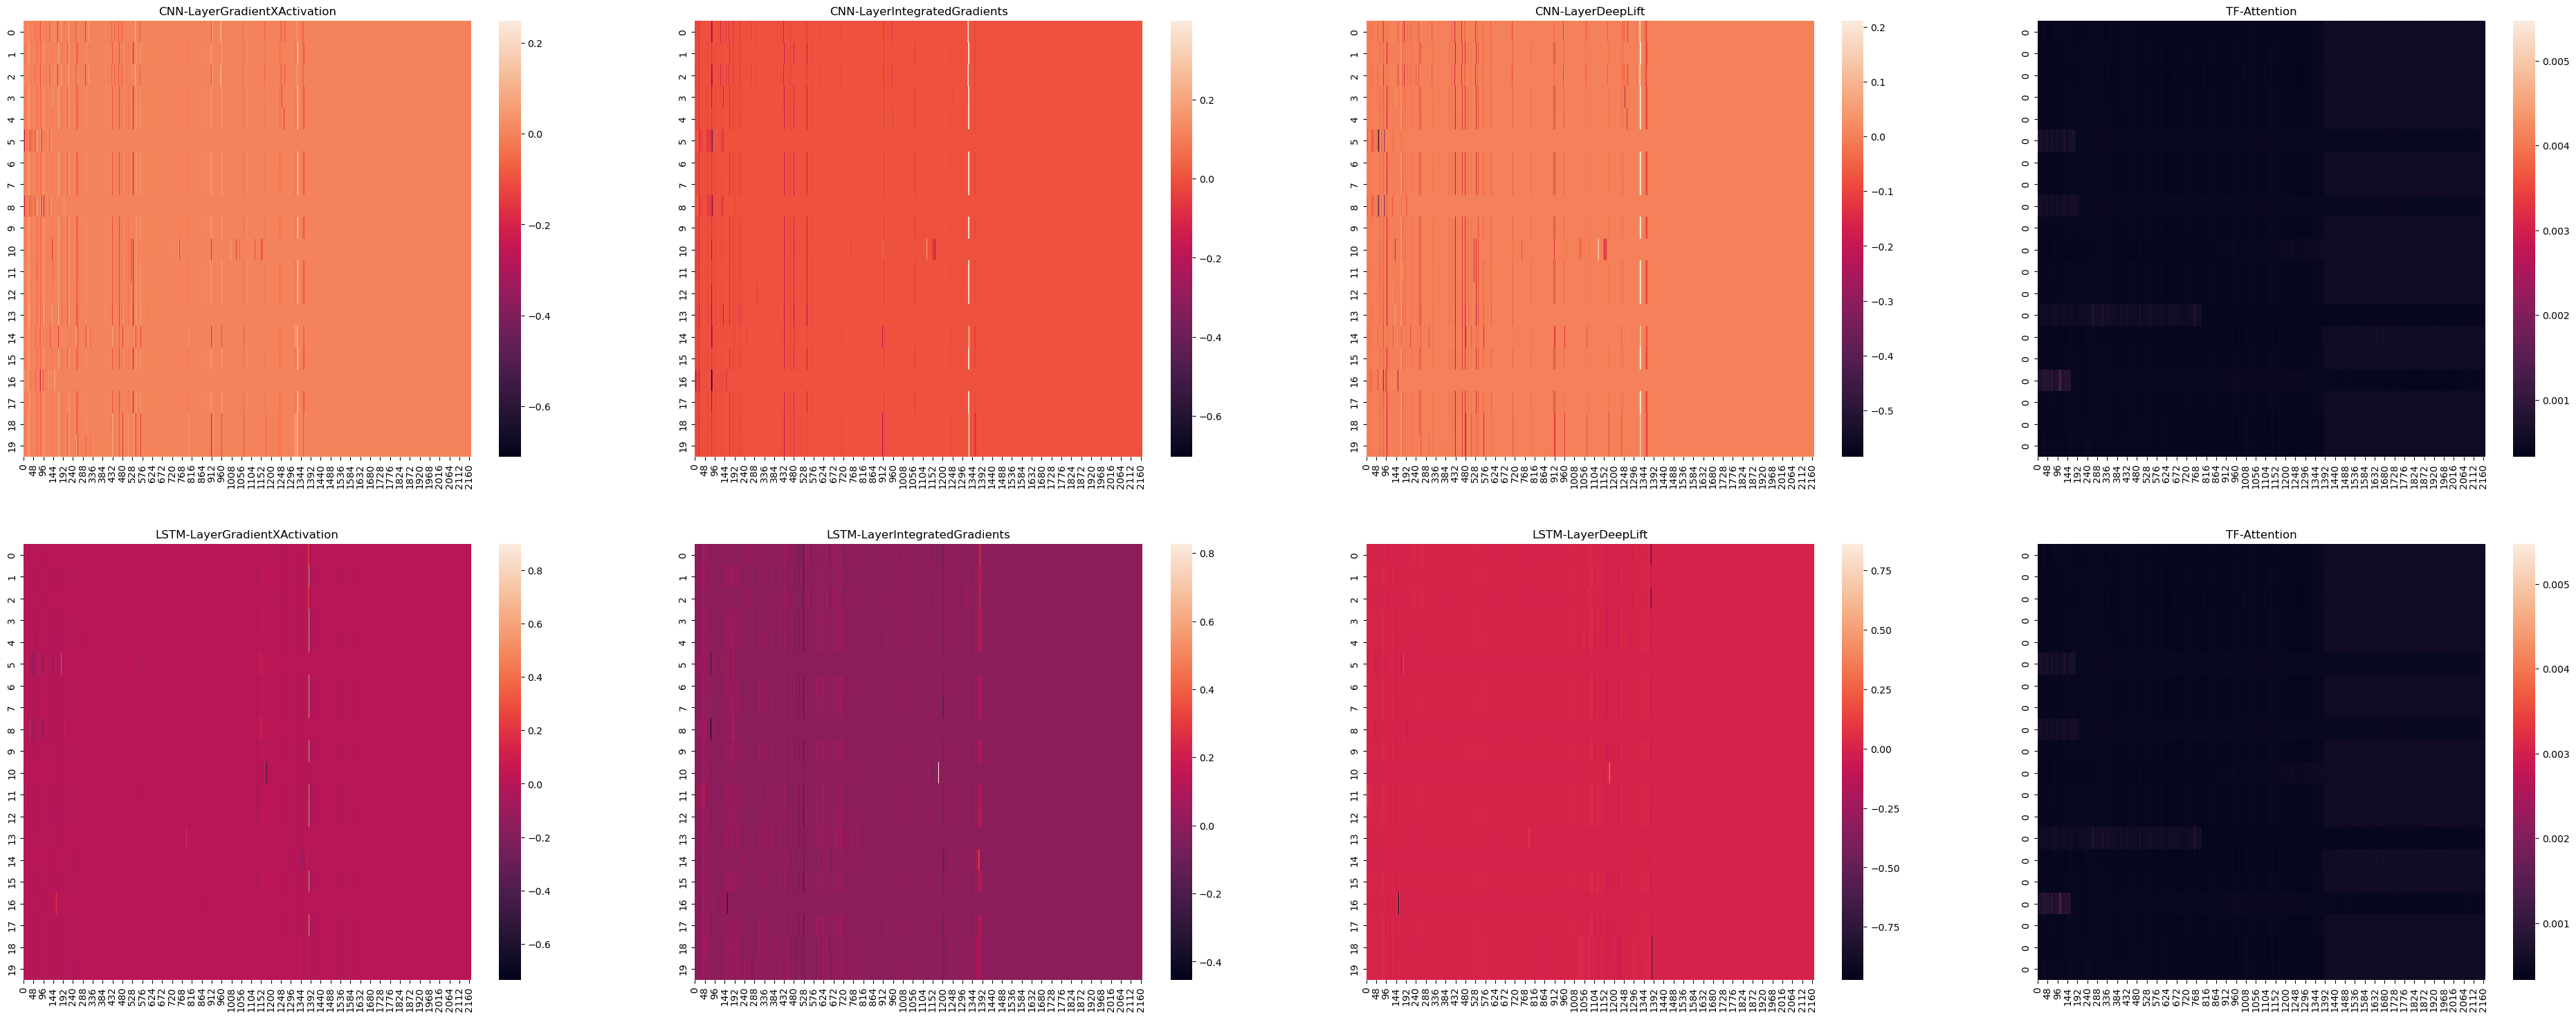

In [44]:
figs, axs = plt.subplots(2, 4, figsize=(48, 18))

def draw_subplot(model, method, class_name, ax):
    entry = list(filter(lambda x: x["model"] == model and x["method"] == method and x["class"] == class_name, n_attr_dfs))[0]
    df = entry["attr_df"]
    sns.heatmap(df, ax=ax)
    ax.set_title(f"{model}-{method}")


# 0, 0: CNN-LayerGradientXActivation
draw_subplot("CNN", "LayerGradientXActivation", "Pig", axs[0, 0])

# 0, 1: CNN-LayerIntegratedGradients
draw_subplot("CNN", "LayerIntegratedGradients", "Pig", axs[0, 1])

# 0, 2: CNN-LayerDeepLift
draw_subplot("CNN", "LayerDeepLift", "Pig", axs[0, 2])

# 0, 3: TF-Attention
draw_subplot("TF", "Attention", "Pig", axs[0, 3])

# 1, 0: LSTM-LayerGradientXActivation
draw_subplot("LSTM", "LayerGradientXActivation", "Pig", axs[1, 0])

# 1, 1: LSTM-LayerIntegratedGradients
draw_subplot("LSTM", "LayerIntegratedGradients", "Pig", axs[1, 1])

# 1, 2: LSTM-LayerDeepLift
draw_subplot("LSTM", "LayerDeepLift", "Pig", axs[1, 2])

# 1, 3: TF-Attention
draw_subplot("TF", "Attention", "Pig", axs[1, 3])

plt.show()

### Single Sequence Attribution Value Analysis

In [45]:
# compute ranks
for entry in single_seq_attr_dfs:
    attr_df = entry["attr_df"]
    attr = attr_df.iloc[0, :].values
    attr_abs = np.abs(attr)
    # top 20 attr values
    entry["top_n_attr"] = np.argsort(attr_abs)[-20:]

In [46]:
entry

{'model': 'TF',
 'method': 'Attention',
 'class': 'Pig',
 'attr_df':        0         1         2         3         4         5         6     \
 0  0.000402  0.000364  0.000411  0.000369  0.000395  0.000385  0.000424   
 
        7         8         9     ...      2159      2160      2161      2162  \
 0  0.000398  0.000373  0.000419  ...  0.000534  0.000532  0.000533  0.000534   
 
        2163      2164      2165      2166      2167      2168  
 0  0.000535  0.000536  0.000537  0.000536  0.000535  0.000534  
 
 [1 rows x 2169 columns],
 'top_n_attr': array([1678, 1674, 1671, 1673, 1562, 1672, 1560, 1675, 1542, 1677, 1676,
        1561, 1570, 1568, 1537, 1569, 1538, 1539, 1541, 1540])}

In [47]:
df = pd.DataFrame(single_seq_attr_dfs)
df.drop(columns="attr_df", inplace=True)

In [48]:
def jaccard_sim(a, b):
    a = set(a)
    b = set(b)
    union = len(a.union(b))
    intersection = len(a.intersection(b))
    return intersection / union

def jaccard_analysis(df):
    df["model-method"] = df["model"] + "-" + df["method"]
    sim_list = []
    model_method_vals = df["model-method"].unique()
    for val_1 in model_method_vals:
        for val_2 in model_method_vals:
            series_1 = list(df[df["model-method"] == val_1]["top_n_attr"].values[0])
            series_2 = list(df[df["model-method"] == val_2]["top_n_attr"].values[0])
            sim_list.append({
                "model-method-1": val_1,
                "model-method-2": val_2,
                "jaccard_sim": jaccard_sim(series_1, series_2)
            })
    sim_df = pd.DataFrame(sim_list)
    sim_df_pivot = sim_df.pivot(columns="model-method-2", index="model-method-1", values="jaccard_sim")
    sns.heatmap(sim_df_pivot, linewidth=.5)
    plt.show()

#### Jaccard similarity between top 20 positions for different model-method combination pairs - Human class

/tmp/ipykernel_15229/1786794281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model-method"] = df["model"] + "-" + df["method"]


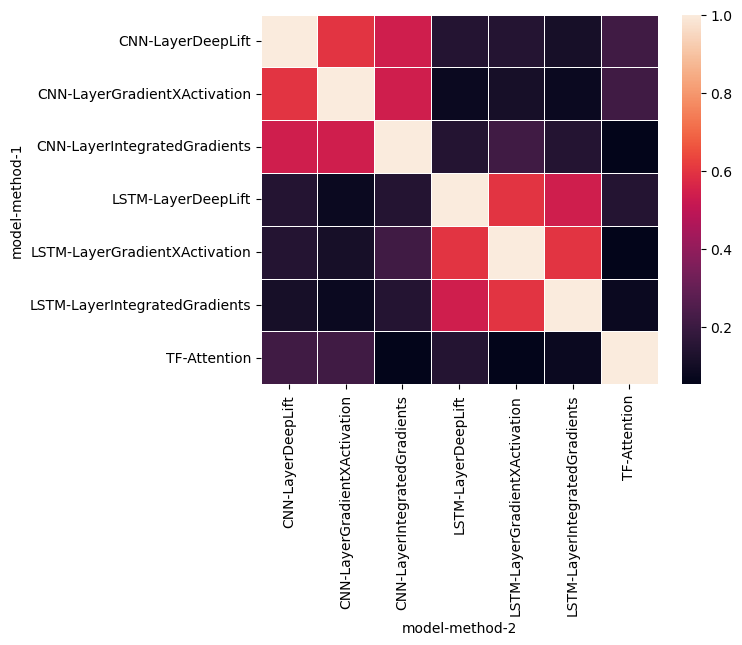

In [49]:
human_df = df[df["class"] == "Human"]
jaccard_analysis(human_df)

#### Jaccard similarity between top 20 positions for different model-method combination pairs - Pig class

/tmp/ipykernel_15229/1786794281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["model-method"] = df["model"] + "-" + df["method"]


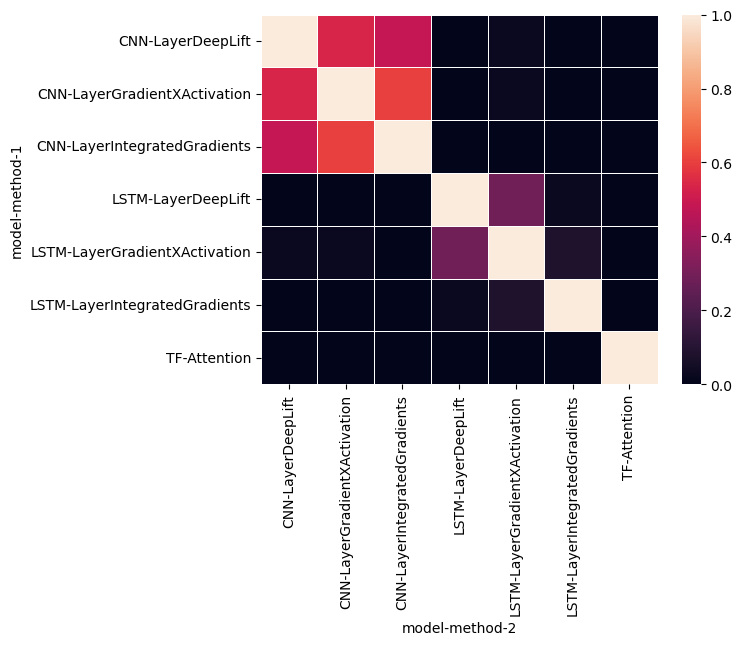

In [50]:
pig_df = df[df["class"] == "Pig"]
jaccard_analysis(pig_df)

In [51]:
df

,model,method,class,top_n_attr
0,CNN,LayerGradientXActivation,Human,"[81, 61, 70, 22, 14, 77, 62, 27, 86, 45, 11, 6..."
1,CNN,LayerGradientXActivation,Pig,"[433, 30, 465, 432, 909, 481, 169, 960, 568, 2..."
2,LSTM,LayerGradientXActivation,Human,"[22, 44, 72, 23, 63, 49, 31, 36, 60, 53, 85, 5..."
3,LSTM,LayerGradientXActivation,Pig,"[100, 1088, 1106, 35, 1384, 1086, 1, 1379, 51,..."
4,CNN,LayerIntegratedGradients,Human,"[68, 63, 79, 61, 12, 80, 69, 22, 62, 64, 85, 5..."
5,CNN,LayerIntegratedGradients,Pig,"[1359, 169, 465, 21, 481, 908, 480, 433, 544, ..."
6,LSTM,LayerIntegratedGradients,Human,"[36, 81, 31, 44, 87, 23, 82, 74, 59, 63, 75, 6..."
7,LSTM,LayerIntegratedGradients,Pig,"[1203, 1364, 1155, 46, 44, 47, 507, 24, 37, 48..."
8,CNN,LayerDeepLift,Human,"[80, 77, 27, 37, 64, 62, 35, 69, 61, 45, 36, 8..."
9,CNN,LayerDeepLift,Pig,"[1329, 913, 479, 465, 464, 915, 960, 532, 100,..."


In [52]:
df["model-method"] = df["model"] + " - " + df["method"]
exploded_df = df.explode("top_n_attr")

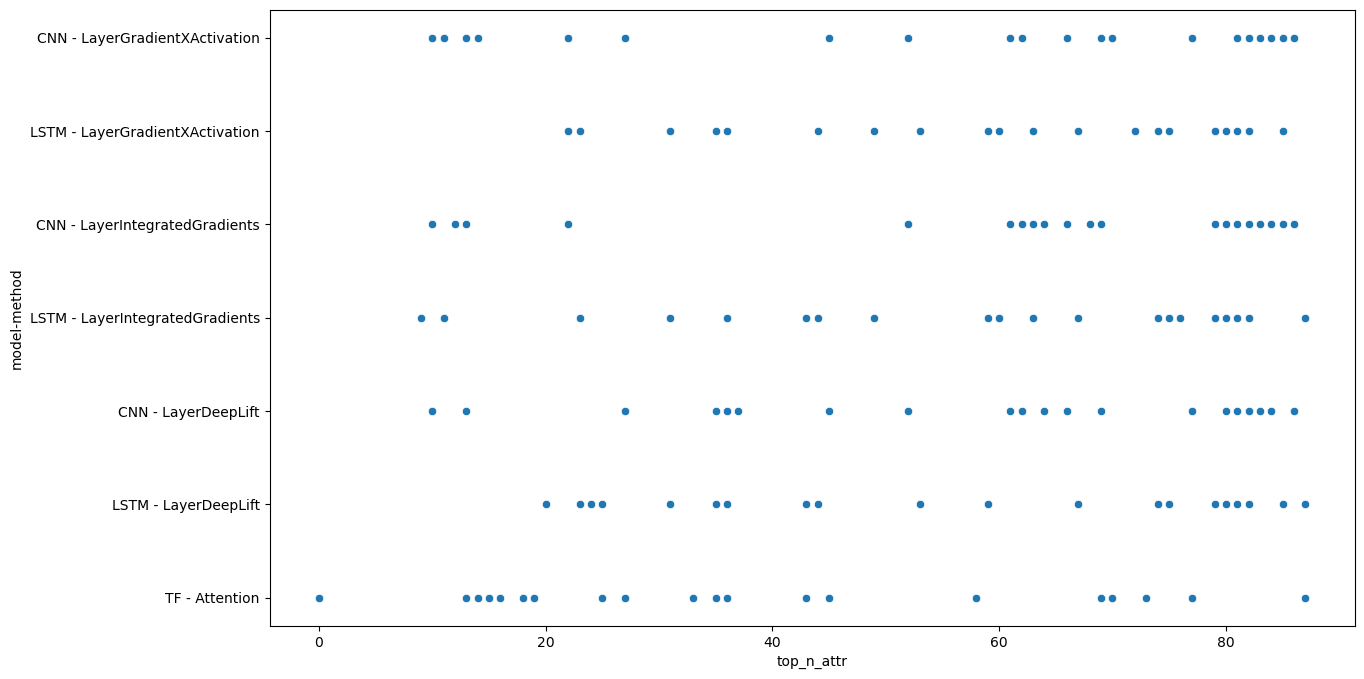

In [53]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(data=exploded_df[exploded_df["class"] == "Human"], x="top_n_attr", y="model-method")
plt.show()

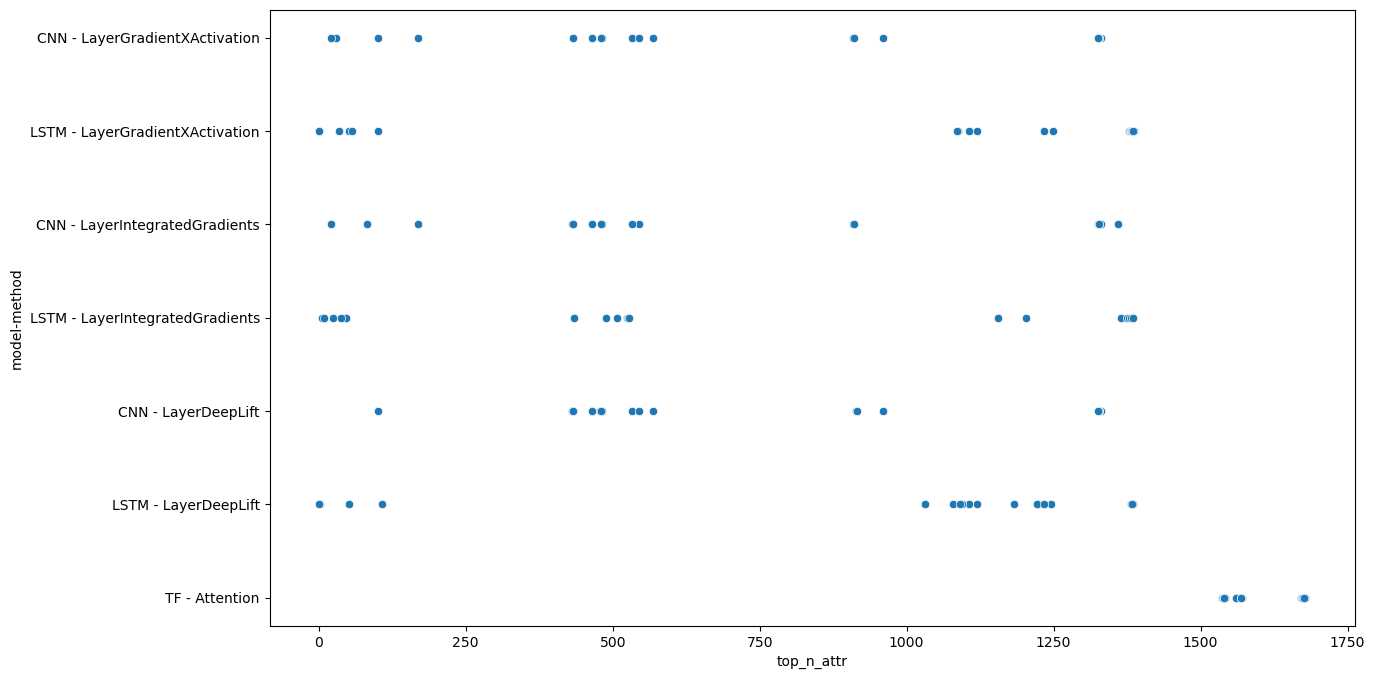

In [54]:
plt.figure(figsize=(14,8))
ax = sns.scatterplot(data=exploded_df[exploded_df["class"] == "Pig"], x="top_n_attr", y="model-method")
plt.show()

### LayerIntegratedGradients and LayerDeepLift with different host reference sequences

In [55]:
label_groupings

{'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'],
 'Human': ['Homo sapiens (Human) [TaxID: 9606]'],
 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'],
 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'],
 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'],
 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'],
 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}

In [56]:
single_seq_attr_diff_ref_dfs = []

for key, value in label_groupings.items():
    target_value = value[0]
    print(f"Key: {key}, Value: {target_value}")
    _, target_dataset_loader = get_target_dataset_loader(target_value)
    ref_seq, ref_label = next(iter(target_dataset_loader))
    
    single_seq_attr_diff_ref_dfs.append({
        "model": "CNN",
        "method": "LayerIntegratedGradients",
        "ref_class": key,
        "attr_df": compute_lig_attributions(cnn_model, [human_input], target=2, reference_seq=reference_seq)
    })

    single_seq_attr_diff_ref_dfs.append({
        "model": "LSTM",
        "method": "LayerIntegratedGradients",
        "ref_class": key,
        "attr_df": compute_lig_attributions(lstm_model, [human_input], target=2, reference_seq=reference_seq)
    })

    single_seq_attr_diff_ref_dfs.append({
        "model": "CNN",
        "method": "LayerDeepLift",
        "ref_class": key,
        "attr_df": compute_ldeeplift_attributions(cnn_model, [human_input], target=2, reference_seq=reference_seq)
    })

    single_seq_attr_diff_ref_dfs.append({
        "model": "LSTM",
        "method": "LayerDeepLift",
        "ref_class": key,
        "attr_df": compute_ldeeplift_attributions(lstm_model, [human_input], target=2, reference_seq=reference_seq)
    })


Key: Pig, Value: Sus scrofa (Pig) [TaxID: 9823]
Size Sus scrofa (Pig) [TaxID: 9823] df = (2620, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

Key: Human, Value: Homo sapiens (Human) [TaxID: 9606]
Size Homo sapiens (Human) [TaxID: 9606] df = (2400, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

Key: Wild turkey, Value: Meleagris gallopavo (Wild turkey) [TaxID: 9103]
Size Meleagris gallopavo (Wild turkey) [TaxID: 9103] df = (36, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

Key: Japanese pipistrelle, Value: Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]
Size Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295] df = (19, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

Key: Lesser bamboo bat, Value: Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]
Size Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959] df = (17, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}

/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

Key: Chicken, Value: Gallus gallus (Chicken) [TaxID: 9031]
Size Gallus gallus (Chicken) [TaxID: 9031] df = (13, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

Key: Bovine, Value: Bos taurus (Bovine) [TaxID: 9913]
Size Bos taurus (Bovine) [TaxID: 9913] df = (10, 9)
Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/gradient_based_interpretation/coronaviridae-aligned/../../../../src/utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebook

In [57]:
single_seq_attr_diff_ref_dfs

[{'model': 'CNN',
  'method': 'LayerIntegratedGradients',
  'ref_class': 'Pig',
  'attr_df':        0         1         2         3         4         5         6     \
  0 -0.000197 -0.001949 -0.004726 -0.006411 -0.003103 -0.004806 -0.002175   
  
         7         8         9     ...  2159  2160  2161  2162  2163  2164  \
  0  0.000803 -0.007064 -0.001909  ...   0.0   0.0   0.0   0.0   0.0   0.0   
  
     2165  2166  2167  2168  
  0   0.0   0.0   0.0   0.0  
  
  [1 rows x 2169 columns]},
 {'model': 'LSTM',
  'method': 'LayerIntegratedGradients',
  'ref_class': 'Pig',
  'attr_df':        0         1         2         3         4         5         6     \
  0 -0.005875  0.004106  0.006772 -0.014556 -0.004497 -0.017441 -0.009398   
  
         7         8         9     ...  2159  2160  2161  2162  2163  2164  \
  0 -0.021152 -0.020268 -0.288467  ...   0.0   0.0   0.0   0.0   0.0   0.0   
  
     2165  2166  2167  2168  
  0   0.0   0.0   0.0   0.0  
  
  [1 rows x 2169 columns]},
 {'

In [58]:
# compute ranks
for entry in single_seq_attr_diff_ref_dfs:
    attr_df = entry["attr_df"]
    attr = attr_df.iloc[0, :].values
    attr_abs = np.abs(attr)
    # top 20 attr values
    entry["top_n_attr"] = np.argsort(attr_abs)[-20:]

In [59]:
df = pd.DataFrame(single_seq_attr_diff_ref_dfs)
df.drop(columns="attr_df", inplace=True)

In [60]:
df

,model,method,ref_class,top_n_attr
0,CNN,LayerIntegratedGradients,Pig,"[68, 63, 79, 61, 12, 80, 69, 22, 62, 64, 85, 5..."
1,LSTM,LayerIntegratedGradients,Pig,"[36, 81, 31, 44, 87, 23, 82, 74, 59, 63, 75, 6..."
2,CNN,LayerDeepLift,Pig,"[80, 77, 27, 37, 64, 62, 35, 69, 61, 45, 36, 8..."
3,LSTM,LayerDeepLift,Pig,"[59, 87, 67, 75, 20, 79, 25, 24, 44, 23, 81, 7..."
4,CNN,LayerIntegratedGradients,Human,"[68, 63, 79, 61, 12, 80, 69, 22, 62, 64, 85, 5..."
5,LSTM,LayerIntegratedGradients,Human,"[36, 81, 31, 44, 87, 23, 82, 74, 59, 63, 75, 6..."
6,CNN,LayerDeepLift,Human,"[80, 77, 27, 37, 64, 62, 35, 69, 61, 45, 36, 8..."
7,LSTM,LayerDeepLift,Human,"[59, 87, 67, 75, 20, 79, 25, 24, 44, 23, 81, 7..."
8,CNN,LayerIntegratedGradients,Wild turkey,"[68, 63, 79, 61, 12, 80, 69, 22, 62, 64, 85, 5..."
9,LSTM,LayerIntegratedGradients,Wild turkey,"[36, 81, 31, 44, 87, 23, 82, 74, 59, 63, 75, 6..."


In [61]:
df["model-method"] = df["model"] + " - " + df["method"]

In [62]:
df

,model,method,ref_class,top_n_attr,model-method
0,CNN,LayerIntegratedGradients,Pig,"[68, 63, 79, 61, 12, 80, 69, 22, 62, 64, 85, 5...",CNN - LayerIntegratedGradients
1,LSTM,LayerIntegratedGradients,Pig,"[36, 81, 31, 44, 87, 23, 82, 74, 59, 63, 75, 6...",LSTM - LayerIntegratedGradients
2,CNN,LayerDeepLift,Pig,"[80, 77, 27, 37, 64, 62, 35, 69, 61, 45, 36, 8...",CNN - LayerDeepLift
3,LSTM,LayerDeepLift,Pig,"[59, 87, 67, 75, 20, 79, 25, 24, 44, 23, 81, 7...",LSTM - LayerDeepLift
4,CNN,LayerIntegratedGradients,Human,"[68, 63, 79, 61, 12, 80, 69, 22, 62, 64, 85, 5...",CNN - LayerIntegratedGradients
5,LSTM,LayerIntegratedGradients,Human,"[36, 81, 31, 44, 87, 23, 82, 74, 59, 63, 75, 6...",LSTM - LayerIntegratedGradients
6,CNN,LayerDeepLift,Human,"[80, 77, 27, 37, 64, 62, 35, 69, 61, 45, 36, 8...",CNN - LayerDeepLift
7,LSTM,LayerDeepLift,Human,"[59, 87, 67, 75, 20, 79, 25, 24, 44, 23, 81, 7...",LSTM - LayerDeepLift
8,CNN,LayerIntegratedGradients,Wild turkey,"[68, 63, 79, 61, 12, 80, 69, 22, 62, 64, 85, 5...",CNN - LayerIntegratedGradients
9,LSTM,LayerIntegratedGradients,Wild turkey,"[36, 81, 31, 44, 87, 23, 82, 74, 59, 63, 75, 6...",LSTM - LayerIntegratedGradients


In [63]:
df["model-method"].unique()

array(['CNN - LayerIntegratedGradients',
       'LSTM - LayerIntegratedGradients', 'CNN - LayerDeepLift',
       'LSTM - LayerDeepLift'], dtype=object)

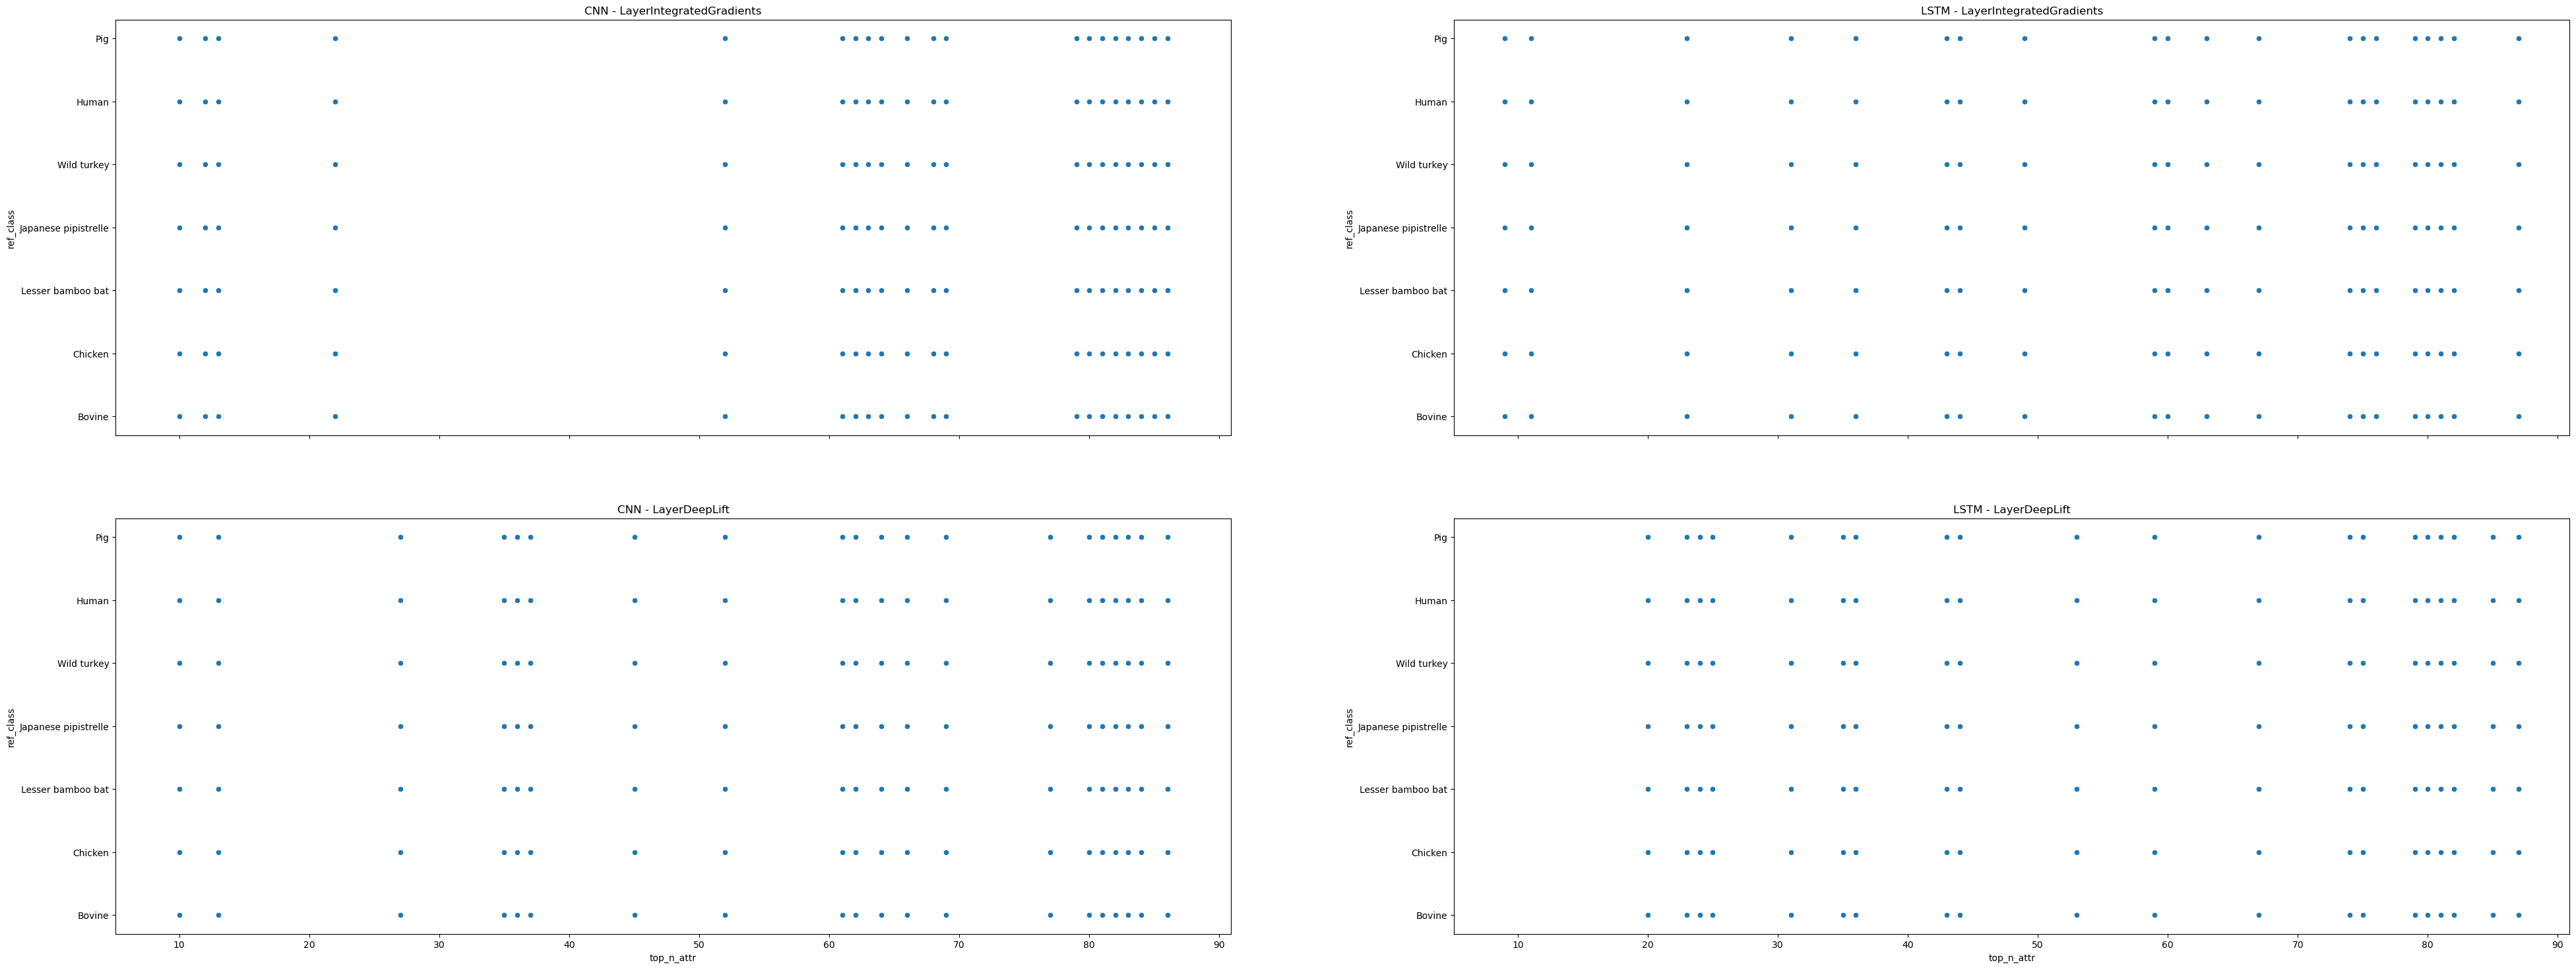

In [64]:
figs, axs = plt.subplots(2, 2, figsize=(48, 18), sharex=True)

def draw_subplot(model_method, ax):
    sub_df = df[df["model-method"] == model_method]
    exploded_sub_df = sub_df.explode("top_n_attr")
    sns.scatterplot(data=exploded_sub_df, x="top_n_attr", y="ref_class", ax=ax)
    ax.set_title(f"{model_method}")


# 0, 0: CNN - LayerIntegratedGradients
draw_subplot("CNN - LayerIntegratedGradients", axs[0, 0])

# 0, 1: LSTM - LayerIntegratedGradients
draw_subplot("LSTM - LayerIntegratedGradients", axs[0, 1])

# 1, 0: CNN - LayerDeepLift
draw_subplot("CNN - LayerDeepLift", axs[1, 0])

# 1, 1: LSTM - LayerDeepLift
draw_subplot("LSTM - LayerDeepLift", axs[1, 1])


plt.show()